# EFTfitter.jl - Tutorial

First, we need to setup EFTfitter, BAT and some other Julia packages:

In [1]:
using EFTfitter
using BAT           # for sampling
using IntervalSets  # for specifying the prior
using Distributions # for specifying the prior
using Plots         # for plotting

---
It is recommended to store the inputs (i.e. parameters, observables, measurements and correlations)
and the actual analysis in two separate files. This allows to simply load different configurations
of the model. We will therefore also consider two files: `tutorial_inputs.jl` and `runTutorial.jl`.

## File "tutorial_inputs.jl"
We start by defining all neccesary inputs to create an
[`EFTfitterModel`](https://tudo-physik-e4.github.io/EFTfitter.jl/dev/api/#EFTfitter.EFTfitterModel).

### Parameters
We specify the parameters our model depends on and choose a prior for each of the parameters.
The prior has to be specified in form of a [BAT.jl prior](https://bat.github.io/BAT.jl/dev/tutorial/#Prior-Definition).

For our example, we consider two parameters with the names `C1` and `C2`.
For `C1` we choose a uniform (flat) prior in the range (-3, 3).
For `C2` we choose a gaussian prior with μ=0 and σ=0.5.

In [2]:
parameters = BAT.NamedTupleDist(
    C1 = -3..3, # short for: Uniform(-3, 3)
    C2 = Normal(0, 0.5) # Normal distribution
)

ValueShapes.NamedTupleDist{(:C1, :C2),Tuple{Distributions.Uniform{Float64},Distributions.Normal{Float64}},Tuple{ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}},ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}}}(
_internal_distributions: (C1 = Distributions.Uniform{Float64}(a=-3.0, b=3.0), C2 = Distributions.Normal{Float64}(μ=0.0, σ=0.5))
_internal_shape: ValueShapes.NamedTupleShape{(:C1, :C2),Tuple{ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}},ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}}}((C1 = ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}(ValueShapes.ScalarShape{Real}(), 0, 1), C2 = ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}(ValueShapes.ScalarShape{Real}(), 1, 1)), 2)
)


A parameter can be fixed (and therefore excluded from the fit) by setting its
prior to a certain value, e.g.: `C2 = 0`.
Also see [here](https://bat.github.io/BAT.jl/dev/tutorial/#Prior-Definition)
for more information on priors in the BAT.jl documentation.

### Observables
We now proceed to implement `Functions` that specify how the predicted values
of the observables depend on the model parameters.
For each observable, we need to provide a `Function` that returns the predicted
value of the observable for certain values of the model parameters. In our example,
we consider two observables (e.g. cross sections) by defining the two functions `xsec1` and `xsec2`.

Note: The functions for the observables may only have the model parameters as
their only argument. You can, however define a function that only depends on
the parameters and that internally calls a more complex function and passes the
corresponding arguments. In this example, the function `xsec2` calls the
function `myfunc` and passes further arguments (`coeffs`).

In [3]:
function xsec1(params)
    c = [20.12, 5.56, 325.556]
    return c[1] * params.C1 + c[2] * params.C1 * params.C2+ c[3] * params.C2
end

function xsec2(params)
    coeffs = [2.12, 4.3, 12.6]
    return myfunc(params, coeffs)
end

function myfunc(params, c)
    return c[1] * params.C1 + c[2] * params.C1 * params.C2+ c[3] * params.C2
end

myfunc (generic function with 1 method)

If your observable is a distribution, you can define a vector of functions
with one function for each bin of the distribution.
(You could also treat each bin as a separate observable as shown above.)

In [4]:
function diff_xsec_bin1(params)
    coeffs = [2.2, 5.5, 6.6]
    return myfunc(params, coeffs)
end

function diff_xsec_bin2(params)
    coeffs = [3.3, 4.8, 7.6]
    return myfunc(params, coeffs)
end

function diff_xsec_bin3(params)
    coeffs = [4.9, 5.6, 8.9]
    return myfunc(params, coeffs)
end

diff_xsec = [diff_xsec_bin1, diff_xsec_bin2, diff_xsec_bin3]

3-element Array{Function,1}:
 diff_xsec_bin1 (generic function with 1 method)
 diff_xsec_bin2 (generic function with 1 method)
 diff_xsec_bin3 (generic function with 1 method)

Note: Another way to define a vector of functions for the bins of distributions
is shown [here](https://tudo-physik-e4.github.io/EFTfitter.jl/dev/advanced_tutorial/#Creating-a-vector-of-functions-for-distributions-1)
in the [advanced tutorial](https://tudo-physik-e4.github.io/EFTfitter.jl/dev/advanced_tutorial/).
This can be particularly useful when the predictions for the individual bins
have a similar functional relation and only differ in terms of some coefficients,
as it is the case here in this example.

### Measurements
We can now enter measurements of the observables.
This is done by defining a [`NamedTuple`](https://docs.julialang.org/en/v1/manual/types/#Named-Tuple-Types)
consisting of [`Measurement`](https://tudo-physik-e4.github.io/EFTfitter.jl/dev/api/#EFTfitter.Measurement)
and [`MeasurementDistribution`](https://tudo-physik-e4.github.io/EFTfitter.jl/dev/api/#EFTfitter.MeasurementDistribution) objects.

A `Measurement` consists of the observable, the measured numerical value and
numerical values for the (multiple types of) uncertainties.
The observable can be passed to the `Measurement` either as an [`Observable`](https://tudo-physik-e4.github.io/EFTfitter.jl/dev/api/#EFTfitter.Observable)
object or as a `Function`. When using the latter, the observable is assumed to be unconstrained.
The uncertainties are passed as a [`NamedTuple`](https://docs.julialang.org/en/v1/manual/types/#Named-Tuple-Types).
Each measurement has to provide uncertainty values for all of the (active) uncertainty
types (see next section on `Correlations`). For a `MeasurementDistribution`,
the corresponding inputs have to be passed as `Vectors`, where each element
represents one bin of the distribution.

A `Measurement` can be excluded from the model by setting the switch `active=false`.
For a `MeasurementDistribution`, the keyword `active` accepts `true` or `false`
to (de)activate the whole distribution or a vector of booleans for (de)activating only certain bins.

In [5]:
measurements = (
    Meas1 = Measurement(xsec1, 21.6, uncertainties = (stat=0.8, syst=1.8, another_unc=2.3),
            active=true), # `active = false`: exclude measurement from fit (default: active = true)

    Meas2 = Measurement(Observable(xsec2, min=0), 1.9,
            uncertainties = (stat=0.6, syst=0.9, another_unc=1.1), active=true),

    MeasDist = MeasurementDistribution(diff_xsec, [1.9, 2.93, 4.4],
               uncertainties = (stat = [0.7, 1.1, 1.2], syst= [0.7, 0.8, 1.3], another_unc = [1.0, 1.2, 1.9]),
               active=[true, false, true]), # `active = false`: exclude all bins from fit, `active = [true, true, false]`: exclude only third bin from fit
)

(Meas1 = EFTfitter.Measurement(EFTfitter.Observable(Main.##442.xsec1, -Inf, Inf), 21.6, (stat = 0.8, syst = 1.8, another_unc = 2.3), true), Meas2 = EFTfitter.Measurement(EFTfitter.Observable(Main.##442.xsec2, 0.0, Inf), 1.9, (stat = 0.6, syst = 0.9, another_unc = 1.1), true), MeasDist = EFTfitter.MeasurementDistribution(EFTfitter.Observable[EFTfitter.Observable(Main.##442.diff_xsec_bin1, -Inf, Inf), EFTfitter.Observable(Main.##442.diff_xsec_bin2, -Inf, Inf), EFTfitter.Observable(Main.##442.diff_xsec_bin3, -Inf, Inf)], [1.9, 2.93, 4.4], (stat = [0.7, 1.1, 1.2], syst = [0.7, 0.8, 1.3], another_unc = [1.0, 1.2, 1.9]), Bool[1, 0, 1], [:bin1, :bin2, :bin3]))

Further information on the constructors see the API documentation of [`Measurement`](https://tudo-physik-e4.github.io/EFTfitter.jl/dev/api/#EFTfitter.Measurement)
and [`MeasurementDistribution`](https://tudo-physik-e4.github.io/EFTfitter.jl/dev/api/#EFTfitter.MeasurementDistribution).

Note: When using only one measurement or only one type of uncertainties,
make sure to insert a comma, like: `uncertainties = (stat = 0.5,)` so that
Julia can parse the [`NamedTuple`](https://docs.julialang.org/en/v1/manual/types/#Named-Tuple-Types) correctly!

### Correlations
The correlations between the uncertainties of the measurements need to be provided
for each of the uncertainty types. We can pass them by defining a `NamedTuple`
of [`Correlation`](https://tudo-physik-e4.github.io/EFTfitter.jl/dev/api/#EFTfitter.Correlation)
objects that contain the corresponding correlation matrices.
The correlation matrix for each type of uncertainty needs to have a size
of ``N \times N``, where ``N`` is the number of measurements, counting each bin of a distribution.
When a certain type of uncertainty should not be considered, it can be deactivated
by setting `active = false`. This means that the uncertainty values given in the
corresponding `Measurement` and `MeasurementDistribution` objects will not be used.

When assuming the uncertainties of all measurements are uncorrelated, you can
use the `NoCorrelation` object for easily passing an identity matrix of the correct size.

When using a large number of measurements, entering the correlation matrix becomes
quite impractical, especially if you want to add further measurements later.
With the function `to_correlation_matrix`, it is possible to enter a correlation
matrix by simply specifying the names of the measurements that should be correlated
and the value of the corresponding correlation coefficient.
When using a `MeasurementDistribution`, the inter-bin correlations can also be
entered by passing a matrix. By appending `_binX` to the name of a `MeasurementDistribution`,
the Xth bin of the distribution can be accessed.
Note: This function is evaluated from top to bottom, so if you overwrite a
specific correlation value, the last value entered will be used.

In [6]:
dist_corr = [1.0 0.5 0.0;
             0.5 1.0 0.0;
             0.0 0.0 1.0]

another_corr_matrix = to_correlation_matrix(measurements,
    (:Meas1, :Meas2, 0.4), # correlate measurements :Meas1 and :Meas2 with a correlation coefficient of 0.4
    (:Meas1, :MeasDist, 0.1), # correlate all bins of :MeasDist with :Meas1 with 0.1
    (:MeasDist, :MeasDist, dist_corr), # correlate the bins of :MeasDist according to the matrix dist_corr
    (:MeasDist_bin2, :MeasDist_bin3, 0.3), # correlate bin2 of :MeasDist with bin3 with 0.3 (overwrites the corresponding element set in the previous line, but ignored in fit since MeasDist_bin2 is inactive)
)

5×5 Array{Float64,2}:
 1.0  0.4  0.1  0.1  0.1
 0.4  1.0  0.0  0.0  0.0
 0.1  0.0  1.0  0.5  0.0
 0.1  0.0  0.5  1.0  0.3
 0.1  0.0  0.0  0.3  1.0

In [7]:
correlations = (
    stat = NoCorrelation(active=true), # will use the identity matrix of the correct size

    syst = Correlation([1.0 0.5 0.3 0.2 0.2;
                        0.5 1.0 0.2 0.2 0.2;
                        0.3 0.2 1.0 0.2 0.2;
                        0.2 0.2 0.2 1.0 0.2;
                        0.2 0.2 0.2 0.2 1.0], active=false), # `active = false`: ignore all uncertainty values and correlations for this type of uncertainty

    another_unc = Correlation(another_corr_matrix, active=true)
)

(stat = EFTfitter.NoCorrelation
  active: Bool true
, syst = EFTfitter.Correlation([1.0 0.5 … 0.2 0.2; 0.5 1.0 … 0.2 0.2; … ; 0.2 0.2 … 1.0 0.2; 0.2 0.2 … 0.2 1.0], false), another_unc = EFTfitter.Correlation([1.0 0.4 … 0.1 0.1; 0.4 1.0 … 0.0 0.0; … ; 0.1 0.0 … 1.0 0.3; 0.1 0.0 … 0.3 1.0], true))

## File "runTutorial.jl"
Here, we create the `EFTfitterModel` from our inputs and run the actual analysis.

We can then build the `EFTfitterModel` which combines all our inputs into
one object that is then used to perform the analysis on.

In [8]:
model = EFTfitterModel(parameters, measurements, correlations)

EFTfitter.EFTfitterModel(ValueShapes.NamedTupleDist{(:C1, :C2),Tuple{Distributions.Uniform{Float64},Distributions.Normal{Float64}},Tuple{ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}},ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}}}(
_internal_distributions: (C1 = Distributions.Uniform{Float64}(a=-3.0, b=3.0), C2 = Distributions.Normal{Float64}(μ=0.0, σ=0.5))
_internal_shape: ValueShapes.NamedTupleShape{(:C1, :C2),Tuple{ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}},ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}}}((C1 = ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}(ValueShapes.ScalarShape{Real}(), 0, 1), C2 = ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}(ValueShapes.ScalarShape{Real}(), 1, 1)), 2)
)
, (Meas1 = EFTfitter.Measurement(EFTfitter.Observable(Main.##442.xsec1, -Inf, Inf), 21.6, (stat = 0.8, another_unc = 2.3), true), Meas2 = EFTfitter.Measurement(EFTfitter.Observable(Main.##442.xsec2, 0.0, Inf), 1.9, (stat = 0.6, a

To sample the posterior distribution, we specify that our `EFTfitterModel`
should be used and then setup BAT.jl to sample the EFTfitter likelihood.

In [9]:
posterior = PosteriorDensity(model)

algorithm = MCMCSampling(mcalg = MetropolisHastings(), nsteps = 10^5, nchains = 4)
samples = bat_sample(posterior, algorithm).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm BAT.PriorSubstitution()
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:174
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 1 tuned, 4 converged.
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC T

For further information on settings & algorithms when sampling with BAT.jl
see the BAT.jl [tutorial](https://bat.github.io/BAT.jl/dev/tutorial/#Parameter-Space-Exploration-via-MCMC)
and [documentation](https://bat.github.io/BAT.jl/dev/stable_api/#BAT.bat_sample).

We can then inspect the results of the sampling using BAT.jl's `SampledDensity`,
giving a summary of the sampling and the results of the model parameters.

In [10]:
sd = SampledDensity(posterior, samples)
display(sd)

Of course, plotting the resulting posterior distributions is also simple
using Plots.jl and the BAT.jl plotting recipes:

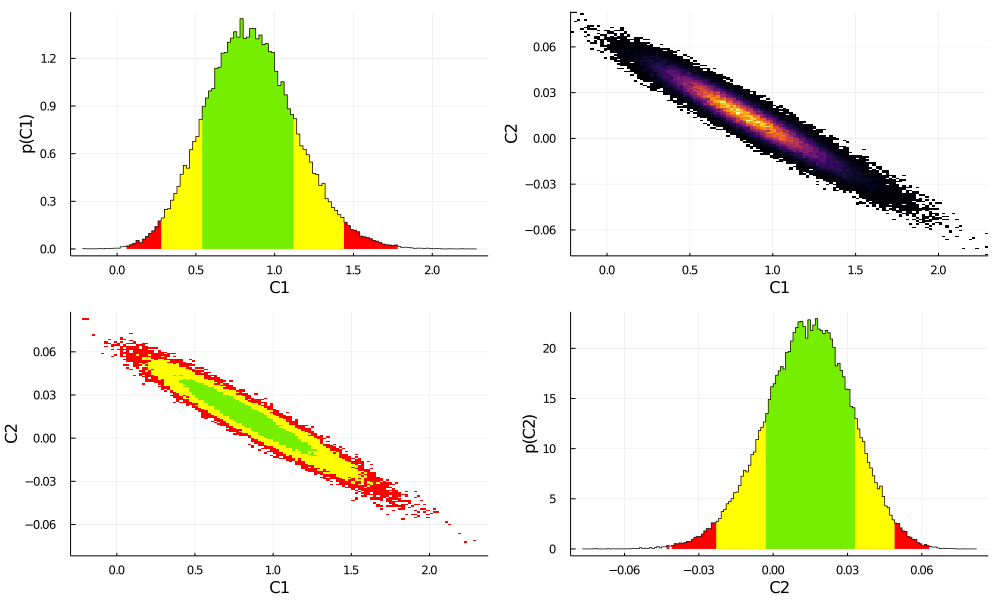

In [11]:
p = plot(samples)

For information on how to customize plots of the samples, please see the BAT.jl
[plotting documentation](https://bat.github.io/BAT.jl/dev/plotting/) and
[examples](https://github.com/bat/BAT.jl/blob/master/examples/dev-internal/plotting_examples.jl).

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*